**Лабораторная работа №3**

Вариант 18

**Цель лабораторной работы:** познакомиться с применением модели машинного обучения для решения задачи классификации (метод логистической регрессии).

Выполним анализ набора данных «Рак молочной железы» (`cancer.csv`). Этот набор данных содержит информацию о диагностике рака молочной железы и включает следующие атрибуты:

*   **age** – возрастная группа пациента
*   **menopause** – менопаузальный статус
*   **tumor-size** – размер опухоли в мм
*   **inv-nodes** – количество инвазивных лимфатических узлов
*   **node-caps** – наличие капсулы лимфатического узла (да/нет)
*   **deg-malig** – степень злокачественности опухоли (1, 2, 3)
*   **breast** – сторона груди (левая/правая)
*   **breast-quad** – квадрант груди, в котором находится опухоль
*   **irradiat** – прошла ли пациентка лучевую терапию (да/нет)
*   **Class** – класс рецидива (рецидив/отсутствие рецидива) – целевая переменная

**1. Импортируем библиотеки и загружаем данные**

In [398]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc

df = pd.read_csv("cancer.csv")
df.head()

,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat,Class
0,30-39,premeno,30-34,0-2,no,3,left,left_low,no,no-recurrence-events
1,40-49,premeno,20-24,0-2,no,2,right,right_up,no,no-recurrence-events
2,40-49,premeno,20-24,0-2,no,2,left,left_low,no,no-recurrence-events
3,60-69,ge40,15-19,0-2,no,2,right,left_up,no,no-recurrence-events
4,40-49,premeno,0-4,0-2,no,2,right,right_low,no,no-recurrence-events


**2. Выведем целевую переменную, целевые имена и частоту каждого уникального значения.**

Unique values of the target variable:  ['no-recurrence-events' 'recurrence-events']
Counts of the target variable: [201  85]


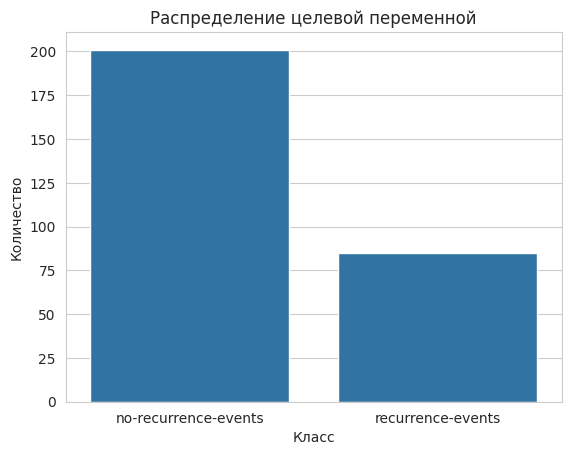

In [399]:
(unique, counts) = np.unique(df['Class'], return_counts=True)
print('Unique values of the target variable: ', unique)
print('Counts of the target variable:', counts)

sns.set_style("whitegrid")
sns.countplot(data=df, x='Class')
plt.xlabel('Класс')
plt.ylabel('Количество')
plt.title('Распределение целевой переменной')
plt.show()

In [400]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          286 non-null    object
 1   menopause    286 non-null    object
 2   tumor-size   286 non-null    object
 3   inv-nodes    286 non-null    object
 4   node-caps    286 non-null    object
 5   deg-malig    286 non-null    int64 
 6   breast       286 non-null    object
 7   breast-quad  286 non-null    object
 8   irradiat     286 non-null    object
 9   Class        286 non-null    object
dtypes: int64(1), object(9)
memory usage: 22.5+ KB


**3. Проверяем наличие пропущенных значений и выбросов.**

In [401]:
print(df.isnull().sum())

age            0
menopause      0
tumor-size     0
inv-nodes      0
node-caps      0
deg-malig      0
breast         0
breast-quad    0
irradiat       0
Class          0
dtype: int64


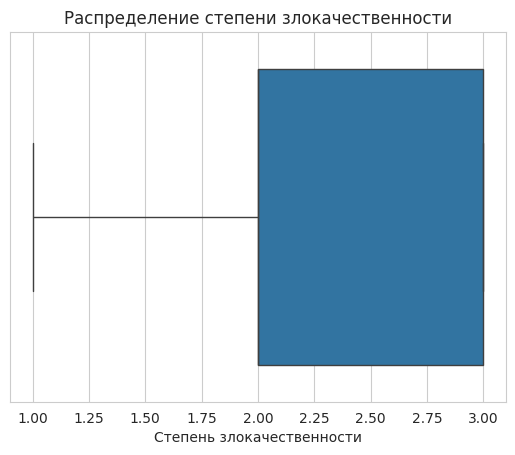

In [402]:
sns.boxplot(x=df['deg-malig'])
plt.xlabel('Степень злокачественности')
plt.title('Распределение степени злокачественности')
plt.show()

**4. Исключаем невлияющие категориальные признаки.**

In [403]:
df_copy = df.copy()
non_influencing_categorical_features = ['breast'] # Удаляем признак 'breast', так как 'breast-quad' предоставляет более детальную информацию о расположении опухоли.
df_copy.drop(non_influencing_categorical_features, axis=1, inplace=True)
df_copy.head()

,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast-quad,irradiat,Class
0,30-39,premeno,30-34,0-2,no,3,left_low,no,no-recurrence-events
1,40-49,premeno,20-24,0-2,no,2,right_up,no,no-recurrence-events
2,40-49,premeno,20-24,0-2,no,2,left_low,no,no-recurrence-events
3,60-69,ge40,15-19,0-2,no,2,left_up,no,no-recurrence-events
4,40-49,premeno,0-4,0-2,no,2,right_low,no,no-recurrence-events


In [404]:
# Определяем словари
menopause_map = {'premeno': 0, 'lt40': 1, 'ge40': 2}
node_caps_map = {'no': 0, 'yes': 1, '?': -1}
breast_quad_map = {'left_low': 0, 'right_up': 1, 'left_up': 2, 'right_low': 3, 'central': 4, '?': -1}
irradiat_map = {'no': 0, 'yes': 1}
class_map = {'no-recurrence-events': 0, 'recurrence-events': 1}
age_map = {'10-19': 0, '20-29': 1, '30-39': 2, '40-49': 3, '50-59': 4, '60-69': 5, '70-79': 6}
tumor_size_map = {'0-4': 0, '5-9': 1, '10-14': 2, '15-19': 3, '20-24': 4, '25-29': 5, '30-34': 6, '35-39': 7, '40-44': 8, '45-49': 9, '50-54': 10}
inv_nodes_map = {'0-2': 0, '3-5': 1, '6-8': 2, '9-11': 3, '12-14': 4, '15-17': 5, '18-20': 6, '21-23': 7, '24-26': 8, '27-29': 9, '30-32': 10, '33-35': 11, '36-39': 12}

df_copy['menopause'] = df_copy['menopause'].replace(menopause_map)
df_copy['node-caps'] = df_copy['node-caps'].replace(node_caps_map)
df_copy['breast-quad'] = df_copy['breast-quad'].replace(breast_quad_map)
df_copy['irradiat'] = df_copy['irradiat'].replace(irradiat_map)
df_copy['Class'] = df_copy['Class'].replace(class_map)
df_copy['age'] = df_copy['age'].replace(age_map)
df_copy['tumor-size'] = df_copy['tumor-size'].replace(tumor_size_map)
df_copy['inv-nodes'] = df_copy['inv-nodes'].replace(inv_nodes_map)

df_copy.head()

/tmp/ipython-input-116390258.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_copy['menopause'] = df_copy['menopause'].replace(menopause_map)
/tmp/ipython-input-116390258.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_copy['node-caps'] = df_copy['node-caps'].replace(node_caps_map)
/tmp/ipython-input-116390258.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the f

,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast-quad,irradiat,Class
0,2,0,6,0,0,3,0,0,0
1,3,0,4,0,0,2,1,0,0
2,3,0,4,0,0,2,0,0,0
3,5,2,3,0,0,2,2,0,0
4,3,0,0,0,0,2,3,0,0


**5. Разделяем данные на признаки и целевую переменную.**

In [405]:
y = df_copy['Class']
X = df_copy.drop('Class', axis=1)

**6. Применяем операцию нормализации для численной устойчивости.**

In [406]:
standardizer = StandardScaler()
X_scaled = standardizer.fit_transform(X)

**7. Разделяем данные на тренировочный и тестовый наборы.**

In [407]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=0)

**8. Обучаем модель логистической регрессии**

In [408]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

**9. Делаем прогноз на основе данных тестирования**

In [409]:
y_pred = model.predict(X_test)

**10. Рассчитываем показатели точности, сравнив фактические и прогнозируемые значения**

In [410]:
cm = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = confusion_matrix(y_test, y_pred).ravel()

print('True Positive(TP) = ', TP)
print('False Positive(FP) = ', FP)
print('True Negative(TN) = ', TN)
print('False Negative(FN) = ', FN)

True Positive(TP) =  7
False Positive(FP) =  5
True Negative(TN) =  42
False Negative(FN) =  18


In [411]:
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.6805555555555556


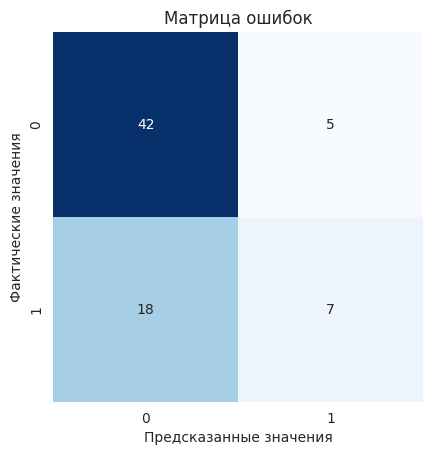

In [412]:
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=False, cmap='Blues')
plt.title('Матрица ошибок')
plt.xlabel('Предсказанные значения')
plt.ylabel('Фактические значения')
plt.show()

In [413]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

Precision: 0.58
Recall: 0.28


In [414]:
f1 = f1_score(y_test, y_pred)
print(f"F1-мера: {f1:.2f}")

F1-мера: 0.38


In [415]:
# Рассчитываем и отображаем матрицу корреляций для преобразованных числовых данных
df_copy.corr()

,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast-quad,irradiat,Class
age,1.000000,0.720322,-0.010559,-0.035112,-0.093049,-0.085968,-0.023858,-0.042080,-0.071719
menopause,0.720322,1.000000,-0.002527,0.034040,-0.068029,0.043490,0.019650,-0.041752,-0.052498
tumor-size,-0.010559,-0.002527,1.000000,0.160487,0.186925,0.218169,-0.157500,0.164418,0.175065
inv-nodes,-0.035112,0.034040,0.160487,1.000000,0.480590,0.329048,-0.043865,0.324176,0.275881
node-caps,-0.093049,-0.068029,0.186925,0.480590,1.000000,0.328815,-0.006903,0.196613,0.237577
deg-malig,-0.085968,0.043490,0.218169,0.329048,0.328815,1.000000,-0.043591,0.208099,0.299400
breast-quad,-0.023858,0.019650,-0.157500,-0.043865,-0.006903,-0.043591,1.000000,-0.037571,-0.093311
irradiat,-0.042080,-0.041752,0.164418,0.324176,0.196613,0.208099,-0.037571,1.000000,0.193912
Class,-0.071719,-0.052498,0.175065,0.275881,0.237577,0.299400,-0.093311,0.193912,1.000000


**11. Строим ROC-кривую.**

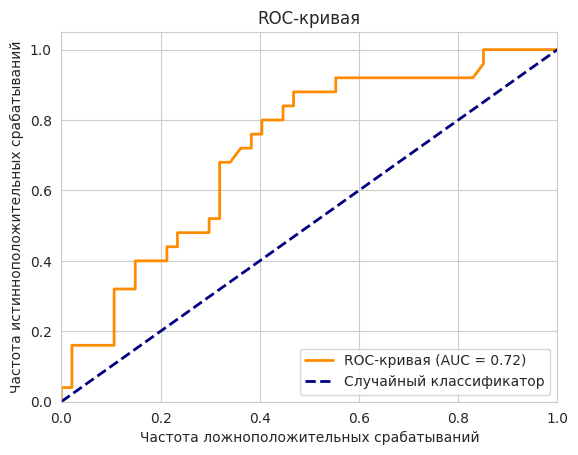

AUC: 0.716


In [416]:
y_score = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_score)

roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC-кривая (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Случайный классификатор')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Частота ложноположительных срабатываний')
plt.ylabel('Частота истинноположительных срабатываний')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"AUC: {roc_auc:.3f}")

Таким образом, в лабораторной работе №3 был проведен анализ датасета cancer.csv с помощью метода логистической регрессии.